In [1]:
import dkist
import dkist.net
from sunpy.net import Fido, attrs as a

import astropy.modeling.models as m
import astropy.units as u
from astropy.coordinates import SpectralCoord

import matplotlib.pyplot as plt
from astropy.visualization import quantity_support

from astropy.modeling.fitting import TRFLSQFitter, parallel_fit_dask
import numpy as np

quantity_support()

%matplotlib widget

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=16, threads_per_worker=1)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 31.27 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44913,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.27 GiB
Comm: tcp://127.0.0.1:45805,Total threads: 1
Dashboard: http://127.0.0.1:36825/status,Memory: 1.95 GiB
Nanny: tcp://127.0.0.1:35707,


First let's fetch some data

In [3]:
res = Fido.search(a.dkist.Dataset("ALDLJ"))

In [4]:
dataset_path = "~/dkist_data/pid_2_114/{dataset_id}"
asdf_file = Fido.fetch(res, path=dataset_path)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [5]:
visp = dkist.load_dataset(asdf_file)

In [6]:
# Have a running globus connect personal endpoint and then run this to download the actual data
#visp.files.download()

In [7]:
visp

This VISP Dataset ALDLJ consists of 1345 frames.
Files are stored in /home/stuart/dkist_data/pid_2_114/ALDLJ

This Dataset has 3 pixel and 4 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<reshape, shape=(1345, 937, 2550), dtype=float64, chunksize=(1, 937, 2550), chunktype=numpy.ndarray>

Array Dim  Axis Name                Data size  Bounds
        0  raster scan step number       1345  None
        1  dispersion axis                937  None
        2  spatial along slit            2550  None

World Dim  Axis Name                  Physical Type                   Units
        3  time                       time                            s
        2  helioprojective latitude   custom:pos.helioprojective.lat  arcsec
        1  wavelength                 em.wl                           nm
        0  helioprojective longitude  custom:pos.helioprojective.lon  arcsec

Correlation between pixel and world axes:

                          | 

Next we will create a cube which is an average spectra over all spatial pixels in the raster scan

In [8]:
spatial_avg = visp.rebin((visp.data.shape[0], 1, visp.data.shape[2]), )[0, :, 0]
spatial_avg._data = spatial_avg.data.compute()

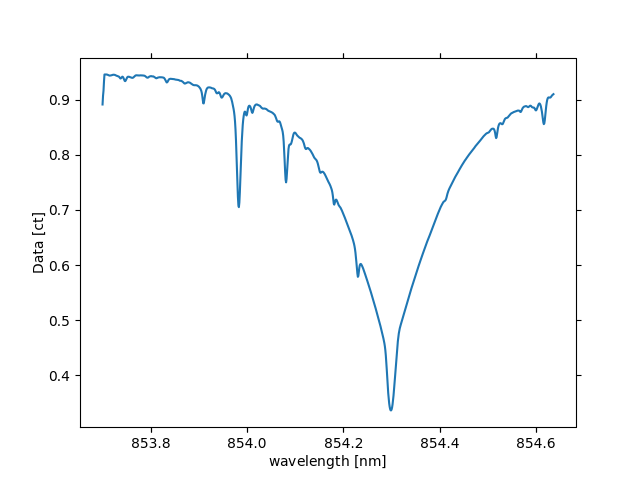

In [9]:
plt.figure()
ax = spatial_avg.plot()

We can see in this plot we have 3 main line centers:

In [10]:
line1 = 854.298 * u.nm
line2 = 853.982 * u.nm
line3 = 854.08 * u.nm

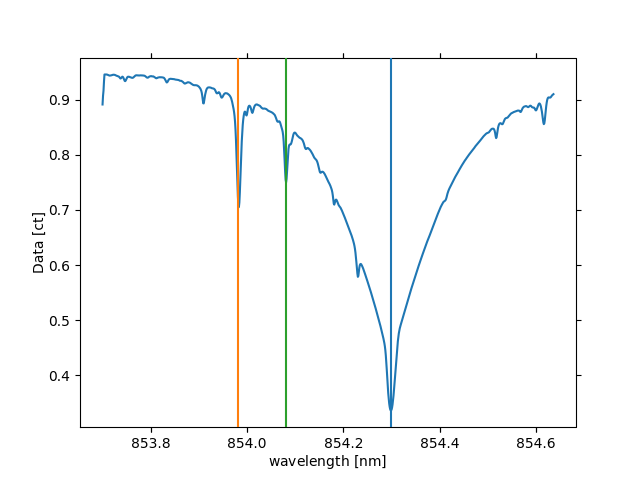

In [11]:
plt.figure()
ax = spatial_avg.plot()
ax.axvline(spatial_avg.wcs.world_to_pixel(SpectralCoord(line1)), color="C0")
ax.axvline(spatial_avg.wcs.world_to_pixel(SpectralCoord(line2)), color="C1")
ax.axvline(spatial_avg.wcs.world_to_pixel(SpectralCoord(line3)), color="C2")

In [12]:
wave_values = spatial_avg.axis_world_coords_values("em.wl").em_wl.to_value(u.nm)

In [13]:
p1 = m.Polynomial1D(
    2,
    c0=0.4,
    c1=0,
    c2=0.6,
    domain=u.Quantity([line1-0.01*u.nm, line1+0.01*u.nm]).to_value(u.nm).tolist(),
    window=[-1, 1],
)
print(p1)
p2 = m.Polynomial1D(
    2,
    c0=0.4,
    c1=0,
    c2=0.6,
    domain=u.Quantity([line2-0.005*u.nm, line2+0.005*u.nm]).to_value(u.nm).tolist(),
    window=[-1, 1],
)
print(p2)
p3 = m.Polynomial1D(
    2,
    c0=0.4,
    c1=0,
    c2=0.6,
    domain=u.Quantity([line3-0.005*u.nm, line3+0.005*u.nm]).to_value(u.nm).tolist(),
    window=[-1, 1],
)
print(p3)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Domain: (854.288, 854.308)
Parameters:
     c0  c1  c2
    --- --- ---
    0.4 0.0 0.6
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Domain: (853.977, 853.987)
Parameters:
     c0  c1  c2
    --- --- ---
    0.4 0.0 0.6
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Domain: (854.075, 854.085)
Parameters:
     c0  c1  c2
    --- --- ---
    0.4 0.0 0.6


In [14]:
def box_from_poly(poly):
    """
    Define a box model restricting the polynominal model to it's domain.
    """
    return m.Box1D(1.0, poly.domain[0] + ((poly.domain[1] - poly.domain[0]) / 2), poly.domain[1] - poly.domain[0],
                   fixed={"amplitude": True, "x_0": True, "width": True})

In [15]:
t1 = p1 * box_from_poly(p1)
t2 = p2 * box_from_poly(p2)
t3 = p3 * box_from_poly(p3)

In [16]:
triple = t1 + t2 + t3

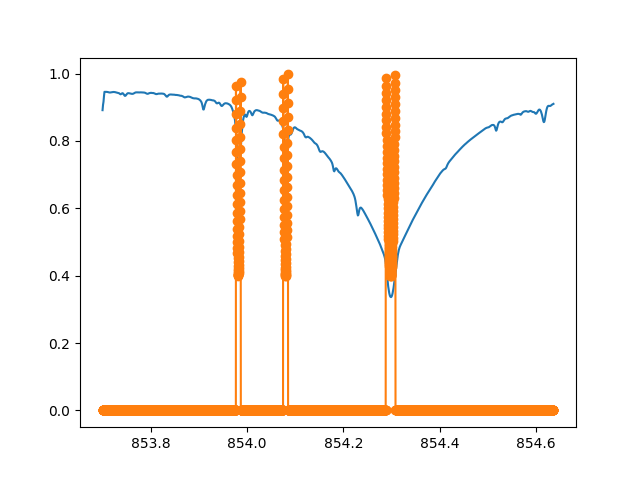

In [17]:
x = np.linspace(wave_values[0], wave_values[-1], 5000)
plt.figure()
plt.plot(wave_values, spatial_avg.data)
plt.plot(x, triple(x), "o-")

In [18]:
fitted = TRFLSQFitter()(triple, wave_values, spatial_avg.data)
print(fitted)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] * [3] + [4] * [5]
Components: 
    [0]: <Polynomial1D(2, c0=0.33833088, c1=-0.01756625, c2=0.0895512, domain=(854.288, 854.308))>

    [1]: <Box1D(amplitude=1., x_0=854.298, width=0.02)>

    [2]: <Polynomial1D(2, c0=0.71569968, c1=-0.03761385, c2=0.09327169, domain=(853.977, 853.987))>

    [3]: <Box1D(amplitude=1., x_0=853.982, width=0.01)>

    [4]: <Polynomial1D(2, c0=0.76279977, c1=-0.02949017, c2=0.06024396, domain=(854.075, 854.085))>

    [5]: <Box1D(amplitude=1., x_0=854.08, width=0.01)>
Parameters:
            c0_0                c1_0         ... x_0_5        width_5       
    ------------------- -------------------- ... ------ --------------------
    0.33833087952827107 -0.01756625459377018 ... 854.08 0.009999999999990905


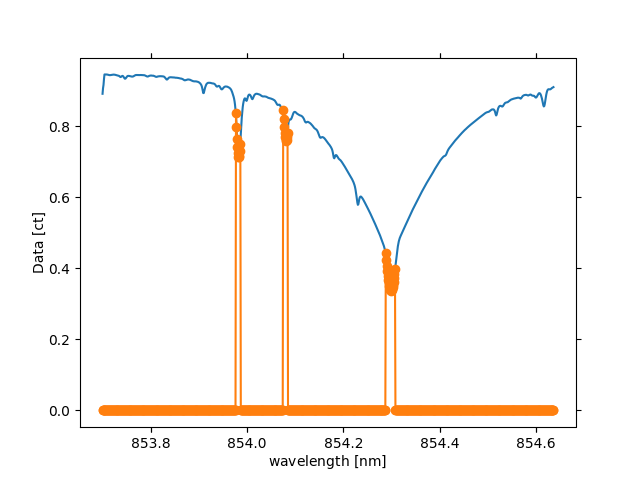

In [19]:
plt.figure()
ax = spatial_avg.plot()
ax.plot(fitted(wave_values), "o-")

In [20]:
def inv_poly_map_domain(x, domain, window):
    """
    Map a coordinate in the window back to the domain.
    """
    scl = (window[1] - window[0]) / (domain[1] - domain[0])
    off = (window[0] * domain[1] - window[1] * domain[0]) / (domain[1] - domain[0])
    return (x - off) / scl


def get_fitted_centers(fitted_model):
    """
    Given a compound model with a bunch of polynominal models in,
    use the quadratic equation to calculate the minimum (or maximum) position.
    """
    centers = []
    for model in fitted_model.traverse_postorder():
        if not isinstance(model, m.Polynomial1D):
            continue
        center = -(model.c1 / (2 * model.c2))
        center = inv_poly_map_domain(u.Quantity(center).value, model.domain, model.window)
        centers.append(center)
    return np.array(centers)

In [21]:
fitted_centers = get_fitted_centers(fitted)

In [22]:
fitted_centers

array([854.29898079, 853.98300818, 854.08122378])

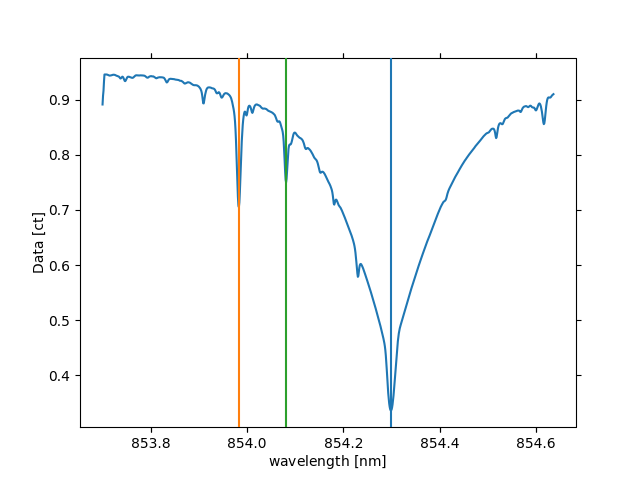

In [23]:
plt.figure()
ax = spatial_avg.plot()
for i, l in enumerate(fitted_centers):
    ax.axvline(spatial_avg.wcs.world_to_pixel(SpectralCoord(l*u.nm)), color=f"C{i}")

In [24]:
# Extract the wavelength axis because of a memory leak in calculating it
wave = visp.axis_world_coords("em.wl")[0]
wave

<SpectralCoord [853.70027376, 853.70127361, 853.70227346, 853.70327331, 853.70427317,
   853.70527302, 853.70627287, 853.70727272, 853.70827258, 853.70927243,
   853.71027228, 853.71127213, 853.71227199, 853.71327184, 853.71427169,
   853.71527154, 853.7162714 , 853.71727125, 853.7182711 , 853.71927095,
   853.72027081, 853.72127066, 853.72227051, 853.72327036, 853.72427022,
   853.72527007, 853.72626992, 853.72726977, 853.72826963, 853.72926948,
   853.73026933, 853.73126918, 853.73226904, 853.73326889, 853.73426874,
   853.73526859, 853.73626845, 853.7372683 , 853.73826815, 853.739268  ,
   853.74026786, 853.74126771, 853.74226756, 853.74326741, 853.74426727,
   853.74526712, 853.74626697, 853.74726682, 853.74826668, 853.74926653,
   853.75026638, 853.75126623, 853.75226609, 853.75326594, 853.75426579,
   853.75526564, 853.7562655 , 853.75726535, 853.7582652 , 853.75926505,
   853.76026491, 853.76126476, 853.76226461, 853.76326446, 853.76426432,
   853.76526417, 853.76626402, 853.767

In [31]:
visp_core_fit = parallel_fit_dask(
    data=visp[:10],
    world=(wave,),
    model=fitted,
    fitter=TRFLSQFitter(),
    fitting_axes=1,
    fitter_kwargs={"filter_non_finite": True}, # Filter out non-finite values,
    preserve_native_chunks=True,
    scheduler="default",
) 

2024-11-06 17:04:15 - astropy - WARNING: Property world has been passed explicitly and as an NDData property wcs, using explicitly specified value
2024-11-06 17:04:15 - astropy - WARNING: The following attributes were set on the data object, but will be ignored by the function: meta


In [32]:
cens = get_fitted_centers(visp_core_fit)

In [33]:
cen_pix = spatial_avg.wcs.world_to_pixel(SpectralCoord(cens*u.nm))

In [34]:
visp

This VISP Dataset ALDLJ consists of 1345 frames.
Files are stored in /home/stuart/dkist_data/pid_2_114/ALDLJ

This Dataset has 3 pixel and 4 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<reshape, shape=(1345, 937, 2550), dtype=float64, chunksize=(1, 937, 2550), chunktype=numpy.ndarray>

Array Dim  Axis Name                Data size  Bounds
        0  raster scan step number       1345  None
        1  dispersion axis                937  None
        2  spatial along slit            2550  None

World Dim  Axis Name                  Physical Type                   Units
        3  time                       time                            s
        2  helioprojective latitude   custom:pos.helioprojective.lat  arcsec
        1  wavelength                 em.wl                           nm
        0  helioprojective longitude  custom:pos.helioprojective.lon  arcsec

Correlation between pixel and world axes:

                          | 

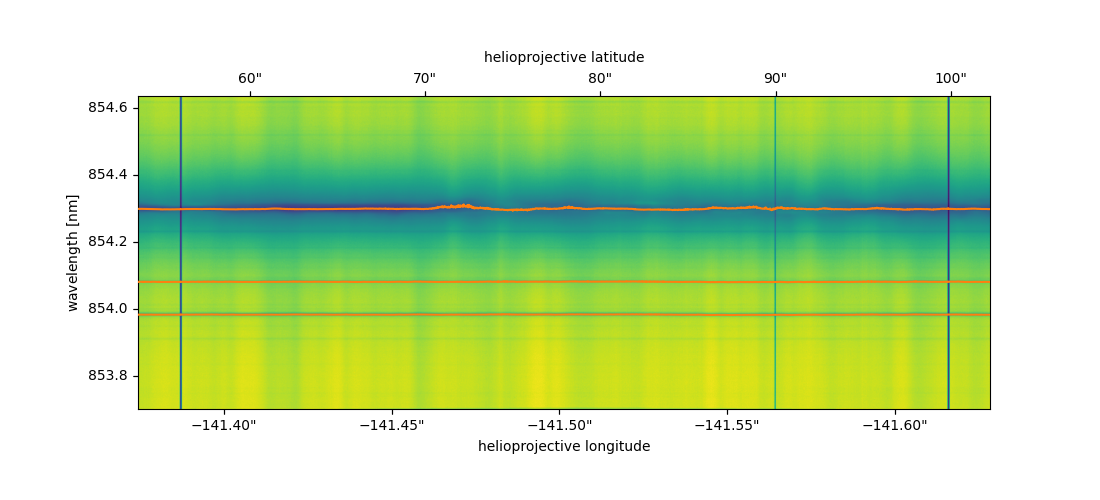

In [35]:
plt.figure(figsize=(11, 5))
ax = visp[0].plot()
ax.plot(np.arange(visp.data.shape[2]), cen_pix[0, 0], color="C1")
ax.plot(np.arange(visp.data.shape[2]), cen_pix[1, 0], color="C1")
ax.plot(np.arange(visp.data.shape[2]), cen_pix[2, 0], color="C1")